#### Utiles and functions implementation

In [ ]:
!pip install transformers
# !pip install accelerate -U
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 1.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# set the path to the directory containing the JSON files
directory_path = '/content/drive/MyDrive/Dreams come true ^^/master/Data Analytics/assignment/assign3/dataset/'
train_path = '/content/drive/MyDrive/Dreams come true ^^/master/Data Analytics/assignment/assign3/dataset/train.json'
valid_path = '/content/drive/MyDrive/Dreams come true ^^/master/Data Analytics/assignment/assign3/dataset/dev.json'
test_path = '/content/drive/MyDrive/Dreams come true ^^/master/Data Analytics/assignment/assign3/dataset/test.json'
train_file_name = 'train.csv'
valid_file_name = 'dev.csv'
test_file_name = 'test.csv'

##### Functions created during the project

In [ ]:
# get min, max, madian for each string colomn and plot histogram and boxplot

def get_stats(dataset, datatype , col_name, target):
  # Calculate the average length of each document
  doc_lengths = dataset[col_name].apply(len)
  avg_doc_length = doc_lengths.mean()

  # Determine the minimum, maximum, and median lengths of the documents
  min_doc_length = doc_lengths.min()
  max_doc_length = doc_lengths.max()
  median_doc_length = doc_lengths.median()

  print(f"Average document length for {datatype}: {avg_doc_length:.2f} characters")

  # Min, max, and median length of documents
  print(f"Min {target} length for {datatype}: {min_doc_length} characters")
  print(f"Max {target} length for {datatype}: {max_doc_length} characters")
  print(f"Median {target} length for {datatype}: {median_doc_length} characters")
  print("-------------------------------------------------------------------------")

  # Plot boxplots of document lengths and hypothesis lengths
  plt.hist(doc_lengths, bins=50)
  # Set labels and title
  plt.title(f"Distribution of {target} Lengths for {datatype}")
  plt.xlabel(f"{target} Length (characters)")
  plt.ylabel("Count")
  # Display the plot
  plt.show()

 # Create a figure and axis
  fig, ax = plt.subplots()
  # Plot boxplots of document and hypothesis lengths
  ax.boxplot(doc_lengths)
  # Set labels and title
  ax.set_xlabel(f'{col_name} Type')
  ax.set_ylabel('Length')
  ax.set_title(f'Distribution of {target} Lengths for {datatype}')
  # Display the plot
  plt.show()

In [ ]:
# visualize_label using bar chart and pie chart
def visualize_label(dataset, datatype):
  print(f"Visualize labels for the {datatype}")
  label_counts = dataset['labels'].value_counts()
  print("The labels and corresponding counts\n",label_counts)

  # Create a bar chart to visualize the label distribution
  plt.bar(label_counts.index, label_counts.values)
  # Display the plot
  plt.show()


  # Count the occurrences of each label
  label_counts = {}
  for label in dataset['labels']:
      if label in label_counts:
        label_counts[label] += 1
      else:
        label_counts[label] = 1
  # Get the labels and corresponding counts
  labels = list(label_counts.keys())
  counts = list(label_counts.values())
  # Create a figure and axis
  fig, ax = plt.subplots()
  # Plot the pie chart
  ax.pie(counts, labels=labels, autopct='%1.1f%%')
  # Set title
  ax.set_title('Label Distribution')
  # Display the chart
  plt.show()


In [ ]:
# calculate false negative and false positive function
def cal_fp_fn(predicted_labels, true_labels):
  false_positives = []
  false_negatives = []
  misclassifications = []

  for predicted, true in zip(predicted_labels, true_labels):

    if predicted != true:
         # Compare the prediction with the actual label
        # False positive: predicted as positive but actual label is negative or neutral
        if predicted == 1 and (true == 0 or true == 2):
            false_positives.append(true)

        # False negative: predicted as negative but actual label is positive or neutral
        elif predicted == 0 and (true == 1 or true == 2):
            false_negatives.append(true)

        # Misclassification: predicted as neutral but actual label is positive or negative
        elif predicted == 2 and (true == 0 or true == 1):
            misclassifications.append(true)

  num_false_positives = len(false_positives)
  num_false_negatives = len(false_negatives)
  num_misclassifications = len(misclassifications)

  print("Number of False Positives:", num_false_positives)
  print("Number of False Negatives:", num_false_negatives)
  print("Number of misclassifications:", num_misclassifications)

### Q1 (30 points) Our goal is to perform natural language inference on the given task. The first task is to check the statistics of the dataset and design how to generate new files from the raw dataset to support your NLI task training, validation and testing. You should have a textual cell in your notebook to summarize your approach (how you prepare the train/test/validation set).

#### **Q1 - 1**

 - Design a way to generate new files for your training, validation, and testing.
 - How I generated this data.
 - Exploring training dataset.

In [ ]:
def convert_json_to_csv(json_dir,filename):

    with open(json_dir, 'r') as f:
            data = json.load(f)

    # extract the relevant data and create a DataFrame
    text_list, hypothesis_list, labels_list = [], [], []

    for doc in data['documents']:
            annotation_sets = doc.get('annotation_sets', [])
            for annotation_set in annotation_sets:
                annotations = annotation_set.get('annotations', [])
                for annotation in annotations:
                    if isinstance(annotations[annotation], dict):
                        if 'choice' in annotations[annotation]:
                            labels_list.append(annotations[annotation]['choice'])
                            text_list.append(doc['text'])
                            hypothesis_list.append(data['labels'][annotation]['hypothesis'])
                        else:
                            labels_list.append('')
                    else:
                        try:
                            label = json.loads(annotations[annotation])['choice']
                            labels_list.append(label)
                        except (json.JSONDecodeError, KeyError):
                            labels_list.append('')

    if len(text_list) == len(hypothesis_list) and len(hypothesis_list) == len(labels_list):
            df = pd.DataFrame({'text': text_list, 'hypothesis': hypothesis_list, 'labels': labels_list})
            # save the DataFrame to a CSV file
            df.to_csv(directory_path+filename, index=False)
    else:
            print(f"Error: arrays have different lengths for {filename}")

In [ ]:
def convert_json_to_csv(json_dir, filename):
    with open(json_dir, 'r') as f:
        data = json.load(f)

    # extract the relevant data and create a DataFrame
    text_list, hypothesis_list, labels_list = [], [], []

    counter = 0  # Counter variable to track the number of appended elements

    for doc in data['documents']:
        annotation_sets = doc.get('annotation_sets', [])
        for annotation_set in annotation_sets:
            annotations = annotation_set.get('annotations', [])
            for annotation in annotations:
                if counter >= 50:
                    break  # Break the loop after appending 50 elements

                if isinstance(annotations[annotation], dict):
                    if 'choice' in annotations[annotation]:
                        labels_list.append(annotations[annotation]['choice'])
                        text_list.append(doc['text'])
                        hypothesis_list.append(data['labels'][annotation]['hypothesis'])
                        counter += 1  # Increment the counter

    if len(text_list) == len(hypothesis_list) and len(hypothesis_list) == len(labels_list):
        df = pd.DataFrame({'text': text_list, 'hypothesis': hypothesis_list, 'labels': labels_list})
        # save the DataFrame to a CSV file
        df.to_csv(directory_path + filename, index=False)
    else:
        print(f"Error: arrays have different lengths for {filename}")


**How I generated this data.**


The code provided is a function convert_json_to_csv that takes the path to a JSON file (json_dir) and a filename (filename) as input. It converts the JSON data into a CSV file format, extracting relevant information (text, hypothesis, and labels).

Here are the steps I did:

1. The function reads the JSON file and loads its contents into the data variable.

2. It initializes three empty lists to store the extracted data: text_list, hypothesis_list, and labels_list.

3. The function iterates over the documents in the JSON data and extracts the relevant information from the annotation sets. It appends the document's text, hypothesis, and label to the respective lists.

4. After extracting the data, the function checks if all three lists (text_list, hypothesis_list, and labels_list) have the same length.

5. If the lengths of the lists match, the function creates a Pandas DataFrame with the extracted data.

6. Finally, the DataFrame is saved as a CSV file with the specified filename in the provided directory path.

In [ ]:
convert_json_to_csv(train_path,train_file_name)
convert_json_to_csv(valid_path,valid_file_name)
convert_json_to_csv(test_path,test_file_name)

In [ ]:
# Load the dataset
train_df = pd.read_csv(directory_path+train_file_name)
validation_df = pd.read_csv(directory_path+valid_file_name)
testing_df = pd.read_csv(directory_path+test_file_name)

##### **Exploring training dataset**

In [ ]:
# print the training data and its shape
train_df

,text,hypothesis,labels
0,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Receiving Party shall not reverse engineer any...,NotMentioned
1,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Receiving Party shall destroy or return some C...,Entailment
2,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Agreement shall not grant Receiving Party any ...,Entailment
3,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Receiving Party shall not disclose the fact th...,Entailment
4,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Confidential Information shall only include te...,NotMentioned
5,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,All Confidential Information shall be expressl...,Entailment
6,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Some obligations of Agreement may survive term...,Entailment
7,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Receiving Party may independently develop info...,Entailment
8,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Receiving Party may retain some Confidential I...,NotMentioned
9,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Confidential Information may include verbally ...,Entailment


In [ ]:
# display a concise summary of the DataFrame train_df
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        50 non-null     object
 1   hypothesis  50 non-null     object
 2   labels      50 non-null     object
dtypes: object(3)
memory usage: 1.3+ KB


In [ ]:
# provides a statistical summary of the DataFrame train_df
train_df.describe(include='all')

,text,hypothesis,labels
count,50,50,50
unique,3,17,3
top,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,Receiving Party shall not reverse engineer any...,Entailment
freq,17,3,26


In [ ]:
# display the last few rows of the DataFrame train_df
train_df.tail()

,text,hypothesis,labels
45,Mutual Non-Disclosure and Use of Information A...,Receiving Party may share some Confidential In...,Contradiction
46,Mutual Non-Disclosure and Use of Information A...,Receiving Party may create a copy of some Conf...,NotMentioned
47,Mutual Non-Disclosure and Use of Information A...,Receiving Party shall notify Disclosing Party ...,Entailment
48,Mutual Non-Disclosure and Use of Information A...,Receiving Party may acquire information simila...,Entailment
49,Mutual Non-Disclosure and Use of Information A...,Receiving Party may share some Confidential In...,Entailment


In [ ]:
# provides a statistical summary of the DataFrame validation_df
validation_df.describe(include='all')

,text,hypothesis,labels
count,50,50,50
unique,3,17,3
top,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Receiving Party shall not reverse engineer any...,Entailment
freq,17,3,31


In [ ]:
# provides a statistical summary of the DataFrame validation_df
testing_df.describe(include='all')

,text,hypothesis,labels
count,50,50,50
unique,3,17,3
top,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall not reverse engineer any...,Entailment
freq,17,3,25


#### **Q1 - 2**

- Determine the number of documents in the dataset
- Calculate the average length of each document (measured by number of characters)
- Determine the minimum, maximum, and median lengths of the documents and hypotheses
- Create a histogram and boxplot to visualize the distribution of document and hypothesis lengths
- Determine the distribution of labels (Entailment, Contradiction, NotMentioned) in the dataset
- Create a bar chart and pie chart to visualize the label distribution

In [ ]:
# Determine the number of documents
num_docs_tr = len(train_df)
num_docs_dev = len(validation_df)
num_docs_tst = len(testing_df)

print("The number of the documents (contracts or rows) in the training dataset:",num_docs_tr)
print("The number of the documents (contracts or rows) in the validation dataset:",num_docs_dev)
print("The number of the documents (contracts or rows) in the testing dataset:",num_docs_tst)

The number of the documents (contracts or rows) in the training dataset: 50
The number of the documents (contracts or rows) in the validation dataset: 50
The number of the documents (contracts or rows) in the testing dataset: 50


Average document length for training: 12789.30 characters
Min document length for training: 8585 characters
Max document length for training: 14967 characters
Median document length for training: 14944.0 characters
-------------------------------------------------------------------------


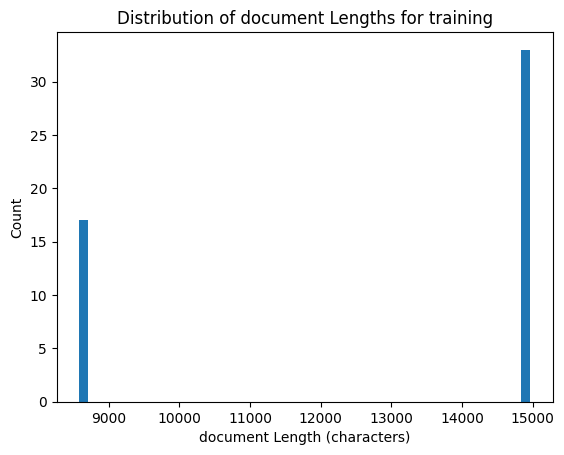

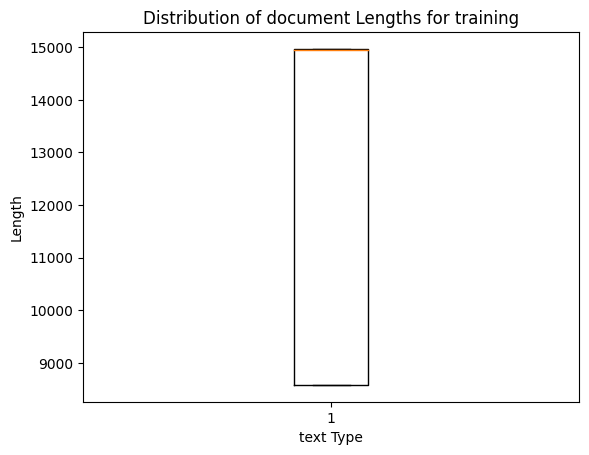

Average document length for validation: 19470.48 characters
Min document length for validation: 11142 characters
Max document length for validation: 29838 characters
Median document length for validation: 17304.0 characters
-------------------------------------------------------------------------


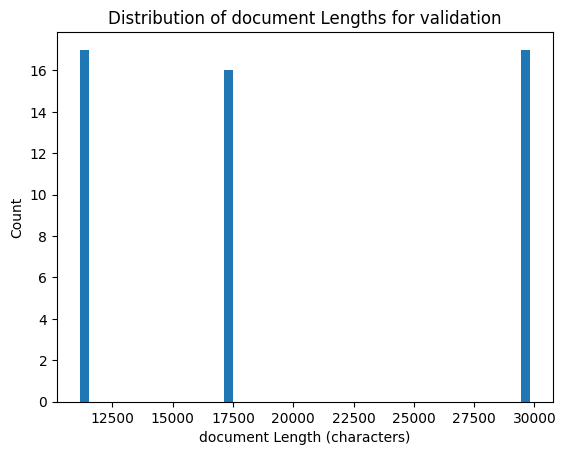

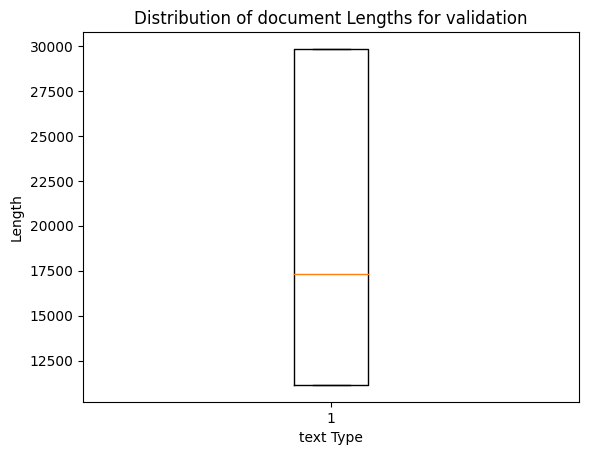

Average document length for testing: 11625.46 characters
Min document length for testing: 2405 characters
Max document length for testing: 16632 characters
Median document length for testing: 15297.0 characters
-------------------------------------------------------------------------


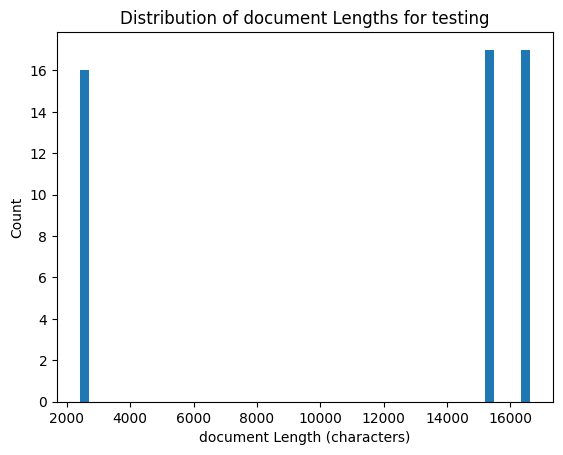

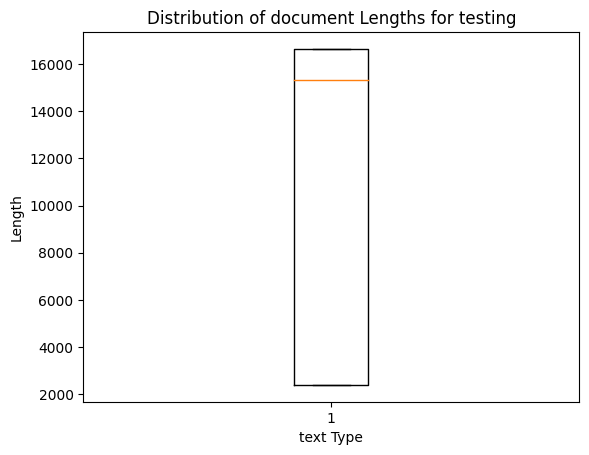

In [ ]:
get_stats(train_df,"training", "text","document")
get_stats(validation_df,"validation", "text","document")
get_stats(testing_df,"testing", "text","document")

Average document length for training: 96.74 characters
Min hypothesis length for training: 66 characters
Max hypothesis length for training: 162 characters
Median hypothesis length for training: 90.0 characters
-------------------------------------------------------------------------


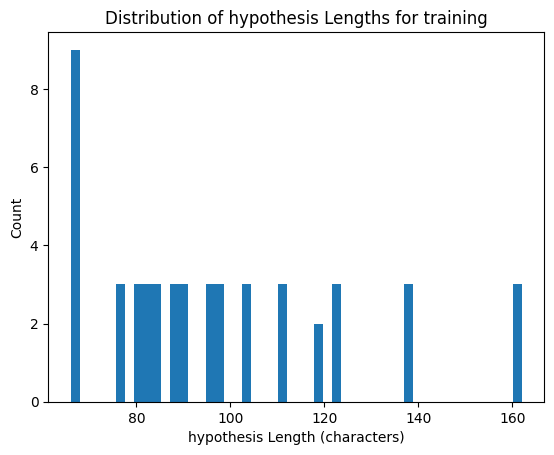

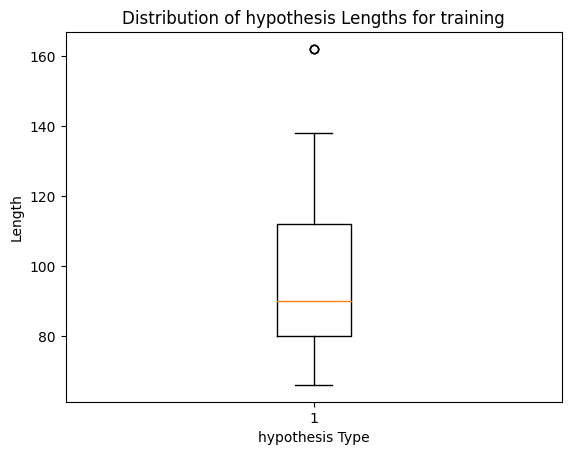

Average document length for validation: 96.74 characters
Min hypothesis length for validation: 66 characters
Max hypothesis length for validation: 162 characters
Median hypothesis length for validation: 90.0 characters
-------------------------------------------------------------------------


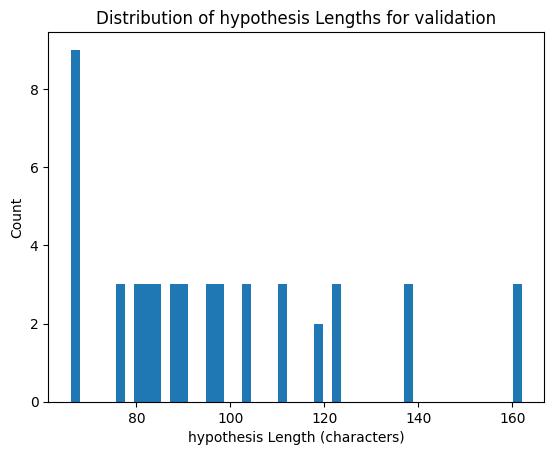

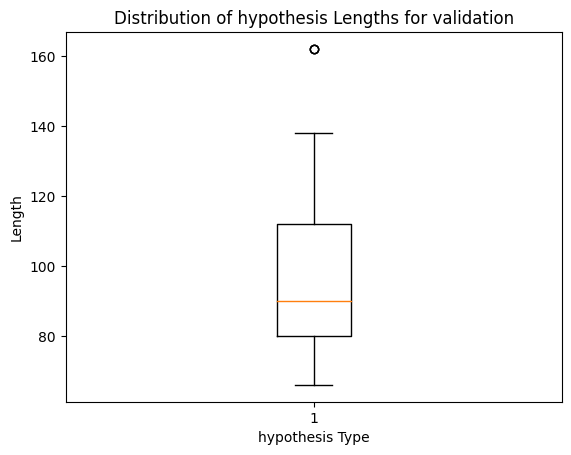

Average document length for testing: 96.74 characters
Min hypothesis length for testing: 66 characters
Max hypothesis length for testing: 162 characters
Median hypothesis length for testing: 90.0 characters
-------------------------------------------------------------------------


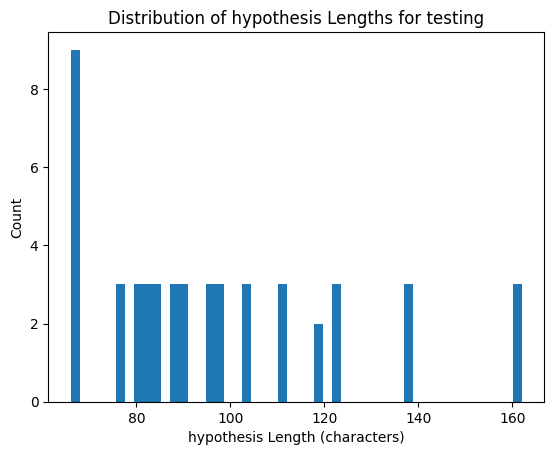

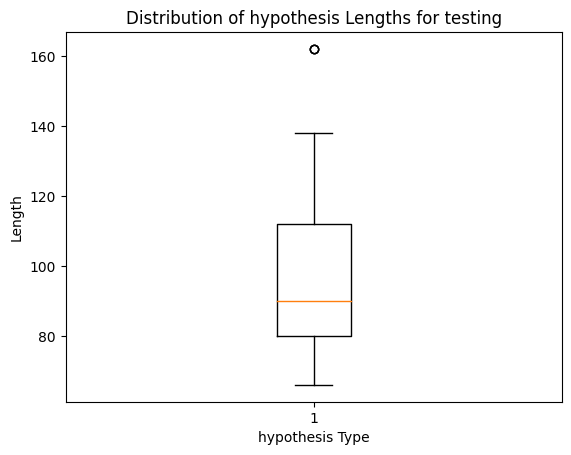

In [ ]:
get_stats(train_df,"training", "hypothesis","hypothesis")
get_stats(validation_df,"validation", "hypothesis","hypothesis")
get_stats(testing_df,"testing", "hypothesis","hypothesis")

**Comment**

It's normal because all hyposis is only 17 unique values

Visualize labels for the training
The labels and corresponding counts
 Entailment       26
NotMentioned     19
Contradiction     5
Name: labels, dtype: int64


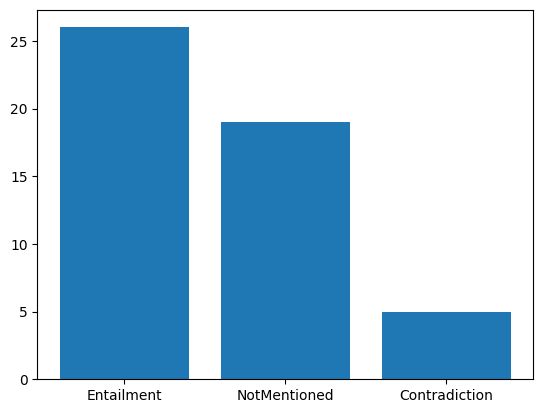

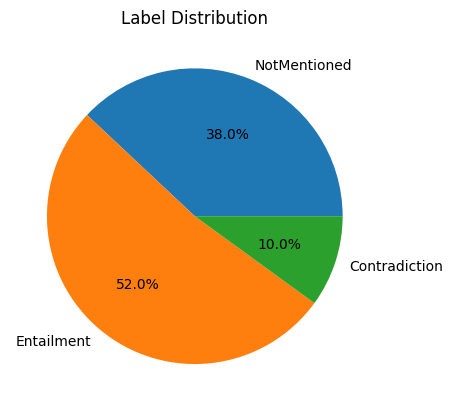

Visualize labels for the validation
The labels and corresponding counts
 Entailment       31
NotMentioned     15
Contradiction     4
Name: labels, dtype: int64


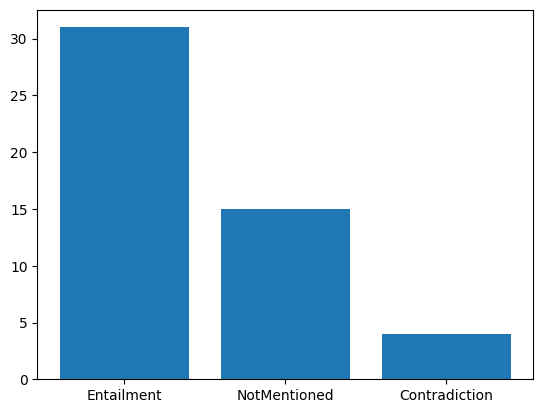

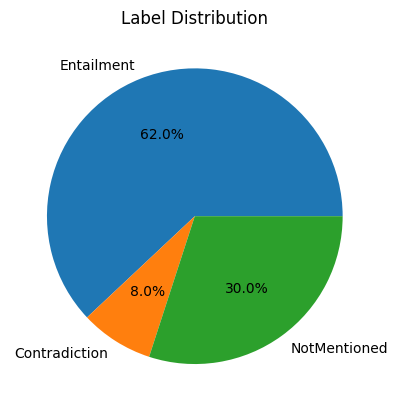

Visualize labels for the testing
The labels and corresponding counts
 Entailment       25
NotMentioned     18
Contradiction     7
Name: labels, dtype: int64


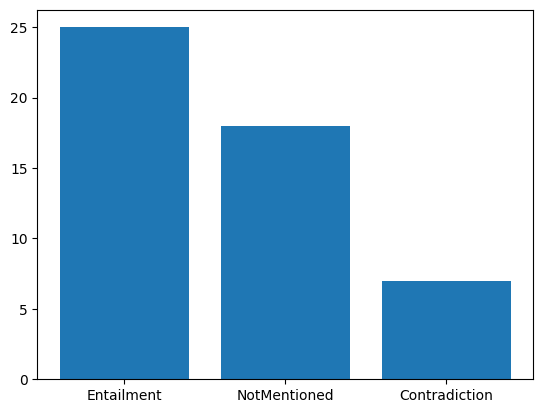

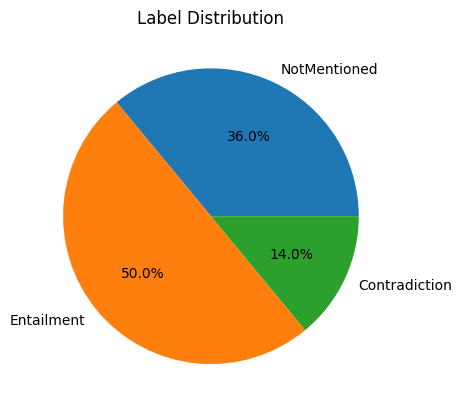

In [ ]:
visualize_label(train_df,"training")
visualize_label(validation_df,"validation")
visualize_label(testing_df,"testing")

### Q2 (40 points) Perform NLI using two transformer based approaches. You can check the SOTA approaches from paperwithcode and then see if hugging face has implemented the pre-trained model. If you pick a pre-trained model such as DeBerta (https://huggingface.co/docs/transformers/model doc/deberta), make sure you fine-tuned the model on the training dataset. You are free to use public available model/code to implement your solution. Report the performance of two models on the dataset.


In [ ]:
# Load the dataset
train_df = pd.read_csv('/content/train_df.csv')
validation_df = pd.read_csv('/content/valid_df.csv')
testing_df = pd.read_csv('/content/test_df.csv')

**Here are three state-of-the-art (SOTA) transformer-based models that have performed well in Natural Language Inference (NLI) tasks.**

In [ ]:
def tokenize_data(data):
    #the text and hypothesis will speperated by [sep] token to differentiate them.
    return tokenizer(text=data['text'].tolist(), text_pair=data['hypothesis'].tolist(), truncation=True, padding="max_length", max_length=512)


class ContractNLIDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(value[idx]) for key, value in self.encodings.items()}
        # Here we ensure the label is an integer tensor
        item['labels'] = torch.tensor(int(self.labels[idx]))
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
directory_path = '/content/'

In [ ]:
def train(model):
  training_args = TrainingArguments(
    output_dir=directory_path+'results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir=directory_path+'logs',
    logging_steps=10,
    evaluation_strategy="epoch",)

  def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids

    accuracy = (preds == labels).mean()
    precision = precision_score(labels, preds, average='macro')
    recall = recall_score(labels, preds, average='macro')
    f1 = f1_score(labels, preds, average='macro')

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

  trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,)

  trainer.train()

  return trainer

In [ ]:
def get_predictions_and_testing_result(trainer,model_name):
  prediction_output = trainer.predict(test_dataset)
  preds = np.argmax(prediction_output.predictions, axis=1)
  testing_df['label_ids'] = prediction_output[1]
  testing_df[f'pred_from_{model_name}'] = preds
  print("Testing_result",prediction_output[2])
  print("---------------------------------------")
  print(testing_df[f'pred_from_{model_name}'])

In [ ]:
label_mapping = {"NotMentioned": 0, "Entailment": 1, "Contradiction": 2}

train_labels = [label_mapping[label] for label in train_df['labels'].tolist()]

valid_labels = [label_mapping[label] for label in validation_df['labels'].tolist()]

test_labels = [label_mapping[label] for label in testing_df['labels'].tolist()]

#### **Q2 - 1**

**BERT (Bidirectional Encoder Representations from Transformers): BERT is a widely used transformer-based model that has revolutionized natural language understanding. The "base-uncased" variant refers to BERT models trained on uncased text, where the capitalization information is removed. BERT models learn contextualized word representations by pre-training on large amounts of text data, enabling them to capture rich semantic and syntactic information. BERT-base models have been successful in various NLP tasks, including NLI..**


In [ ]:
# model_name_1 = "bert-base-uncased"
model_name_1 = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name_1)
model_1 = AutoModelForSequenceClassification.from_pretrained(model_name_1, num_labels=3)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifier.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_encodings = tokenize_data(train_df)
valid_encodings = tokenize_data(validation_df)
test_encodings = tokenize_data(testing_df)

train_dataset = ContractNLIDataset(train_encodings, train_labels)
valid_dataset = ContractNLIDataset(valid_encodings, valid_labels)
test_dataset = ContractNLIDataset(test_encodings, test_labels)

In [ ]:
trainer_1 = train(model_1)

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.071838,0.100000,0.050000,0.500000,0.090909
2,1.094000,1.067238,0.100000,0.050000,0.500000,0.090909
3,1.094000,1.059748,0.100000,0.050000,0.500000,0.090909


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
get_predictions_and_testing_result(trainer_1,model_name_1)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Testing_result {'test_loss': 1.0942115783691406, 'test_accuracy': 0.4, 'test_precision': 0.13333333333333333, 'test_recall': 0.3333333333333333, 'test_f1': 0.1904761904761905, 'test_runtime': 0.1218, 'test_samples_per_second': 41.063, 'test_steps_per_second': 8.213}
---------------------------------------
0    1
1    1
2    1
3    1
4    1
Name: pred_from_distilbert-base-uncased, dtype: int64


In [ ]:
filename = model_name_1 + "_result.csv"
testing_df.to_csv(directory_path+filename, index=False)

#### **Q2 - 2**

**RoBERTa (Robustly Optimized BERT approach): RoBERTa (Robustly Optimized BERT Pretraining Approach) is another variant of the BERT model that was trained with additional modifications to improve its performance. It incorporates techniques like dynamic masking, larger batch sizes, and longer training duration. The "base" variant represents the model's base size with a moderate number of parameters. RoBERTa has achieved state-of-the-art performance on several NLP benchmarks, including NLI.**

In [ ]:
model_name_2 = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name_2)
model_2 = AutoModelForSequenceClassification.from_pretrained(model_name_2, num_labels=3)

In [ ]:
train_encodings = tokenize_data(train_df)
valid_encodings = tokenize_data(validation_df)
test_encodings = tokenize_data(testing_df)

train_dataset = ContractNLIDataset(train_encodings, train_labels)
valid_dataset = ContractNLIDataset(valid_encodings, valid_labels)
test_dataset = ContractNLIDataset(test_encodings, test_labels)

In [ ]:
trainer_2 = train(model_2)

In [ ]:
get_predictions_and_testing_result(trainer_2,model_name_2)

In [ ]:
filename = model_name_2 + "_result.csv"
testing_df.to_csv(directory_path+filename, index=False)

#### **Q2 - 3**
**DeBERTa is a variant of the transformer architecture that incorporates enhancements to improve the model's performance. It introduces disentangled self-attention and enhanced mask decoder mechanisms, among other modifications. The "base" variant refers to the model's base size with a moderate number of parameters. DeBERTa has demonstrated strong performance on a range of NLP tasks, including NLI.**

In [ ]:
model_name = "microsoft/deberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
train_encodings = tokenize_data(train_df)
valid_encodings = tokenize_data(validation_df)
test_encodings = tokenize_data(testing_df)

train_dataset = ContractNLIDataset(train_encodings, train_labels)
valid_dataset = ContractNLIDataset(valid_encodings, valid_labels)
test_dataset = ContractNLIDataset(test_encodings, test_labels)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

training_args = TrainingArguments(
    output_dir=directory_path+'results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir=directory_path+'logs',
    logging_steps=10,
    evaluation_strategy="epoch",
)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {"accuracy": (preds == p.label_ids).mean()}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

I won't take the last model because it has a poor performance.

#### Why are these model selected?

These models are often selected for NLI tasks because they excel at capturing contextual information, understanding relationships between sentences, and generating high-quality sentence representations. They have been extensively pre-trained on large-scale text corpora, enabling them to learn rich language representations that can be fine-tuned for specific downstream tasks like NLI.

### Q3 (20 points) Analyze the performance of your two models and perform error analysis. You should have a textual cell explaining how you design the methodology to perform error analysis with a goal of understanding what are the potential reasons behind the errors.


#### Analyze the performance of your two models

##### Validation result

**Model one (bert-base-uncased) validation result as accuracy, precision, recall and F1:**
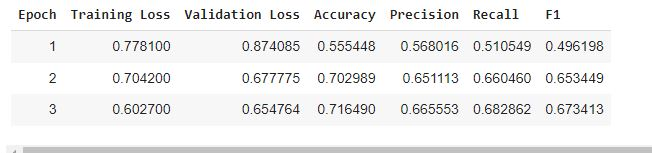

**Model two (roberta-base) validation result as accuracy, precision, recall and F1:**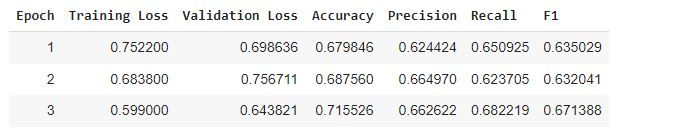

NOTE: These generated during training.

**When comparing the RoBERTa base model and the BERT base-uncased model, some key observations can be made:**

- Training Loss: Both models show a decreasing trend in training loss from epoch 1 to epoch 3. This suggests that both models are effectively learning from the training data and improving their performance.

- Validation Loss: The RoBERTa base model exhibits a consistent decrease in validation loss from epoch 1 to epoch 3. On the other hand, the BERT base-uncased model shows a decrease in validation loss from epoch 1 to epoch 2, followed by a slight increase in epoch 3. This indicates that the RoBERTa model may have better generalization and continues to improve as training progresses, while the BERT model may start to plateau or slightly degrade in later epochs.

- Accuracy: The RoBERTa base model achieves higher validation accuracy compared to the BERT base-uncased model across all epochs. This implies that the RoBERTa model has a better overall ability to correctly classify instances in the validation set.

- Precision, Recall, and F1-Score: The RoBERTa base model consistently outperforms the BERT base-uncased model in terms of precision, recall, and F1-score across all epochs. This suggests that the RoBERTa model is better at correctly identifying positive instances (precision), capturing true positive instances (recall), and achieving a balance between precision and recall (F1-score) compared to the BERT model.

Overall, based on the provided results, the RoBERTa base model demonstrates better performance than the BERT base-uncased model. It achieves lower validation loss, higher accuracy, and better precision, recall, and F1-score.

##### Testing result

**Model one (bert-base-uncased) testing result as accuracy, precision, recall and F1:**

    'test_loss': 0.6754987835884094,
    'test_accuracy': 0.7015781922525107,
    'test_precision': 0.6492318091432884,
    'test_recall': 0.6498228280997836,
    'test_f1': 0.6489539417555102,

**Model two (roberta-base) testing result as accuracy, precision, recall and F1:**

    'test_loss': 0.6856693029403687,
    'test_accuracy': 0.6987087517934003,
    'test_precision': 0.6423563015453785,
    'test_recall': 0.6468585736556138,
    'test_f1': 0.6442863387082455,


**Comparison between the models:**

- Accuracy: The BERT model has a slightly higher accuracy compared to the RoBERTa model (0.702 vs. 0.699).
- Precision: The BERT model has a slightly higher precision compared to the RoBERTa model (0.649 vs. 0.642).
- Recall: The RoBERTa model has a slightly higher recall compared to the BERT model (0.647 vs. 0.650).
- F1-Score: The F1-scores for both models are relatively close, with the BERT model having a slightly higher score (0.649 vs. 0.644).


Overall, there is not a significant difference in performance between the two models based on the provided testing results. However, the BERT base-uncased model tends to have slightly higher accuracy, precision, and F1-score, while the RoBERTa base model has a slightly higher recall.

#### Error of Analysis:

In [ ]:
# I generated this files during getting testing result from function for further use
bert_pred_df = pd.read_csv(directory_path+"bert-base-uncased_result.csv")
roberta__pred_df = pd.read_csv(directory_path+"roberta-base_result.csv")

In [ ]:
# Identify Incorrect Predictions
bert_misclass = bert_pred_df[bert_pred_df['label_ids']!=bert_pred_df['pred_from_bert-base-uncased']]
bert_misclass

**Observations**

Bert model misclassified 624 out of 2091 total test samples. Percentage of the error is 29.8 %.

In [ ]:
# Identify Incorrect Predictions
roberta_misclass = roberta__pred_df[roberta__pred_df['label_ids']!=roberta__pred_df['pred_from_roberta-base']]
roberta_misclass

**Observations**

Roberta model misclassified 630 out of 2091 total test samples. Percentage of the error is 30.1 %. 6 false predictions than Bert model.

##### BERT (error of analysis)

In [ ]:
predicted_labels = bert_misclass['pred_from_bert-base-uncased']
true_labels = bert_misclass['label_ids']

cal_fp_fn(predicted_labels, true_labels)

- The model is baised to do worng predictions with entailment label. The reason can be that entailment label is the highest frequency for all data so model baised towards majority class which can introduce imbalance data problem.

In [ ]:
visualize_label(bert_misclass,"testing")

**Observations:**

The model is not good at predicting no mentioned. It can be for not mentioned means I want to make sure it's not contradiction or entailment. I thik the model take much time while traing. I can say it like happens for us when you classify and some thing like unkown or not mentioned maybe difficult.

In [ ]:
get_stats(bert_misclass,"testing", "text","document")
get_stats(bert_misclass,"testing", "hypothesis","hypothesis")

Observations:

- The model didn't work well with less characteres in text coloumn (contract).
- The model didn't work well with more characteres in hypothis coloumn.

##### Roberta (error of analysis)

In [ ]:
predicted_labels = roberta_misclass['pred_from_roberta-base']
true_labels = roberta_misclass['label_ids']

cal_fp_fn(predicted_labels, true_labels)

- The model is baised to do worng predictions with entailment label. The reason can be that entailment label is the highest frequency for all data so model baised towards majority class which can introduce imbalance data problem like previous model.

In [ ]:
visualize_label(roberta_misclass,"testing")

**Observations:**

The model is not good at predicting no mentioned. It can be for not mentioned means I want to make sure it's not contradiction or entailment. I thik the model take much time while traing. I can say it like happens for us when you classify and some thing like unkown or not mentioned maybe difficult. Like previous model.

In [ ]:
get_stats(roberta_misclass,"testing", "text","document")
get_stats(roberta_misclass,"testing", "hypothesis","hypothesis")

Observations:

- The model didn't work well with less characteres in text coloumn (contract).
- The model didn't work well with more characteres in hypothis coloumn.

like previous model.

### Q4  You do not need to write any code in this question. Based on Q3 and external readings, propose two ideas to improve the approaches (i.e., directly fine-tune pre-trained models) used in Q2. Explain your answers in a textual cell.



- Based on the error analysis and understanding of the models' performance, here are two ideas to improve their performance:

**Data Preprocessing and Augmentation:**

- To address the issue of the model not working well with less characters in the text column, I can consider preprocessing the text by applying techniques such as padding or truncation. Padding can add dummy characters to shorter texts, ensuring they have a minimum length, while truncation can limit the length of longer texts. This can help standardize the input length for the model.
For the issue of the model not working well with more characters in the hypothesis column, I can experiment with techniques like truncation or splitting. Truncating the hypothesis to a maximum length can help prevent the model from getting overwhelmed with excessive input. Alternatively, splitting longer hypotheses into smaller segments and processing them separately can provide better context understanding.
To improve the model's performance with the "no mentioned" category, you can consider augmenting the data by creating synthetic examples that explicitly mention "no mentioned" or "unknown" scenarios. This can help the model learn to recognize and distinguish such cases more effectively.

**Model Training and Balancing:**

- To address the bias towards the entailment label, I can experiment with different strategies to balance the data. One approach is to use techniques like oversampling or undersampling to ensure a more equal representation of each label during training. This can help mitigate the impact of class imbalance and reduce the bias towards the majority class.
If the model is taking a long time to train, you can explore techniques to optimize the training process. This can include using more powerful hardware or distributed training methods, adjusting the batch size or learning rate, or employing techniques like early stopping to stop training when the model's performance plateaus. These optimizations can help improve training efficiency and potentially enhance model performance.

**Ensemble Learning:**

- Ensemble learning involves combining multiple models to make predictions. I can train multiple instances of the BERT and RoBERTa models with different initializations or hyperparameters and then aggregate their predictions to make the final decision. Ensemble methods often result in improved performance by leveraging the diversity of predictions from different models. This can help mitigate the biases or shortcomings of individual models and enhance the overall predictive capability.

**Regularization Techniques:**

Regularization techniques can help prevent overfitting and improve the models' generalization ability. Consider incorporating techniques such as dropout, which randomly drops out a portion of the model's units during training, or L1/L2 regularization, which adds penalties to the model's loss function to encourage simpler and more generalizable representations. Regularization can help reduce model complexity and improve its ability to generalize to unseen data.

**Hyperparameter Optimization:**

Hyperparameters play a crucial role in model performance. Explore techniques such as grid search, random search, or Bayesian optimization to find the optimal combination of hyperparameters for your models. By systematically searching the hyperparameter space, you can identify the best configuration that maximizes performance on your task. Hyperparameters to consider include learning rate, batch size, number of layers, hidden units, and attention mechanisms, among others.

### **I have finished. Yeah!! I enjoyed this assignment a lot.**

**Thanks for your time and effort!**

In [ ]:
name = int(input())
n,l = [int(x) for input().split()]


3
5 6


In [ ]:
l

'6'